In [2]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/bin/imports.ipynb")
execute_notebook("/cellar/users/ramarty/Projects/kir/KIR_development/data_gathering/alternate/sample_mapping.ipynb")

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


## Evaluate a normalization method based on tightness of anchor gene distribution

What infrustructre can I setup to do this systematically and well? <br>
Write one example of a test, then figure out the best parameter to optimize <br>
What k-mers should be used for the anchor gene itself? What does that distribution look like? <br>
Look for tightest distribution across all populations

#### Without normalization

In [3]:
df_whole = pd.concat([pd.read_csv('/cellar/users/ramarty/Data/kir/components/alternate/components_four_counts.csv', index_col=0),
                      pd.read_csv('/cellar/users/ramarty/Data/kir/components/tcga/components_four_counts.csv', index_col=0)])

In [4]:
population_dictionary.keys()

['2017_dbGap_phs000254.v2.p1_NHLBILungCF',
 '2017_dbGap_phs000632.v1.p1_NHLBIFamHC',
 'TCGA',
 'TCGA_agilent',
 '2017_dbGap_phs000362.v1.p1_NHLBIFamFAF',
 '2017_dbGap_phs000209.v13.p3_MESA',
 '2017_dbGap_phs000290.v1.p1_NHLBILungPAH',
 '2017_dbGap_phs000179.v5.p2_GenEpidCOPD',
 '2017_dbGap_phs000631.v1.p1_ARDSnet',
 '2017_dbGap_phs000291.v2.p1_NHLBILungCOPD',
 '2017_dbGap_phs000422.v1.p1_NHLBILungA',
 '2017_dbGap_phs000518.v1.p1_NHLBIFamIB']

In [5]:
# population
samples = population_dictionary_stripped[population_dictionary.keys()[3]]
df_whole = df_whole.ix[samples].dropna()
len(samples), len(df_whole)

(3156, 725)

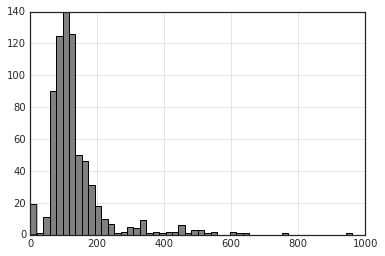

In [6]:
df_whole[kmers[20]['KIR3DL3']].median(axis=1).hist(color='grey', bins=50)

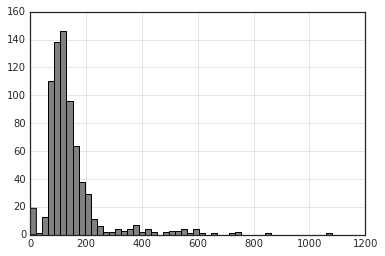

In [7]:
df_whole[kmers[20]['KIR3DL3']].mean(axis=1).hist(color='grey', bins=50)

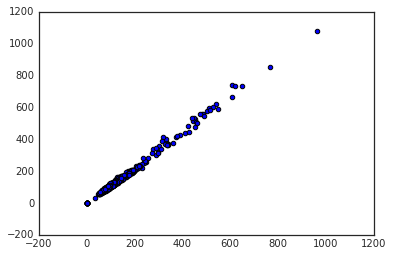

In [8]:
plt.scatter(df_whole[kmers[20]['KIR3DL3']].median(axis=1), df_whole[kmers[20]['KIR3DL3']].mean(axis=1))

In [9]:
df_whole[kmers[20]['KIR3DL3']].median(axis=1).std() / df_whole[kmers[20]['KIR3DL3']].median(axis=1).mean()

0.72473936646880566

Conclusion: mean and median give about the same result -- maybe just stick with median because of outliers

#### With normalization

In [10]:
ref_genes

['PVR', 'ZNF17', 'FUT3', 'JUND', 'RAX2', 'ATP1A3', 'NOTCH3']

In [11]:
df_whole = pd.concat([pd.read_csv('/cellar/users/ramarty/Data/kir/components/alternate/components_four_read_counts.csv', index_col=0),
                      pd.read_csv('/cellar/users/ramarty/Data/kir/components/tcga/components_four_read_counts.csv', index_col=0)])

In [12]:
# exclude low coverage
df_whole = df_whole.ix[[x for x in df_whole.index if x not in sorta_low_coverage_patients]]

In [13]:
anchor1 = df_whole[kmers[20]['KIR3DL3']].median(axis=1)

In [14]:
large_populations, size = [], []
for i, population in enumerate(population_dictionary.keys()):
    samples = population_dictionary_stripped[population]
    df_tmp = df_whole.ix[samples].dropna()
    if len(df_tmp) > population_size_cutoff:
        large_populations.append(population)
        size.append(len(df_tmp))
plotting_df = pd.DataFrame({'Population': large_populations,
                            'Size': size})
plotting_df = plotting_df.sort_values('Size', ascending=False)

KIR3DL3


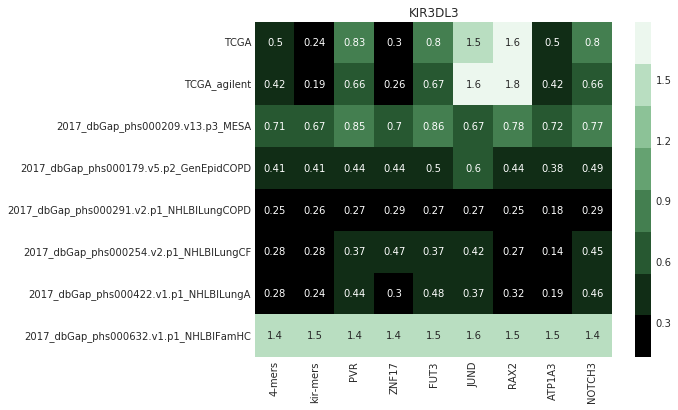

KIR3DP1


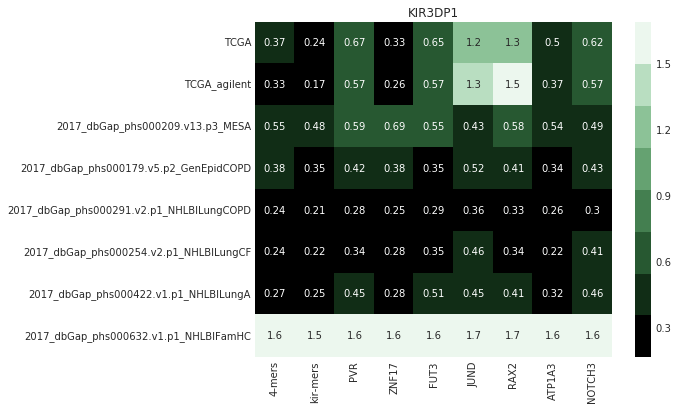

KIR2DL4


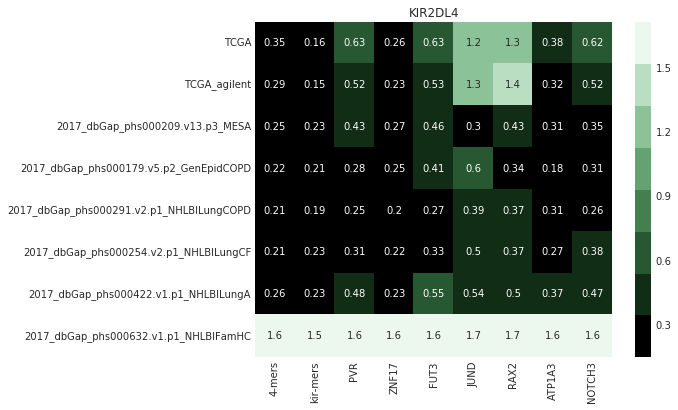

KIR3DL2


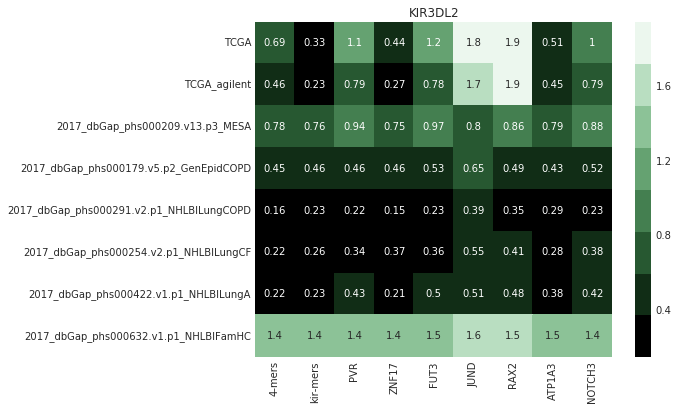

In [15]:
for anchor in ['KIR3DL3', 'KIR3DP1', 'KIR2DL4', 'KIR3DL2']:
    print anchor
    spread, populations_used = [], []
    for population in plotting_df.Population:
        population_spread = []
        samples = population_dictionary_stripped[population]
        df_tmp = df_whole.ix[samples].dropna()
        if len(df_tmp) > population_size_cutoff: 
            populations_used.append(population)
            #print population, len(df_tmp)
            anchor1 = df_tmp[kmers[20][anchor]].sum(axis=1)
            # Assess different techniques
            # four_mers
            normalizer = df_tmp[four_mers].sum(axis=1)
            population_spread.append((anchor1 / normalizer).std() / (anchor1 / normalizer).mean())
            # all kir reads
            normalizer = df_tmp[all_kir_kmers].sum(axis=1)
            population_spread.append((anchor1 / normalizer).std() / (anchor1 / normalizer).mean())
            # alternate genes
            for gene in ref_genes:
                try:
                    normalizer = df_tmp[refs[gene]].sum(axis=1)
                    population_spread.append((anchor1 / normalizer).std() / (anchor1 / normalizer).mean())
                except:
                    population_spread.append(np.nan)
            spread.append(population_spread)
    fig, ax = plt.subplots(figsize=(8,6)) 
    sns.heatmap(spread, annot=True, cmap=sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True),
               xticklabels=['4-mers', 'kir-mers']+ref_genes, yticklabels=populations_used)
    plt.title(anchor)
    plt.show()
    plt.clf()

#### Normalized histograms

0.0 0.767647058824
KIR3DL3


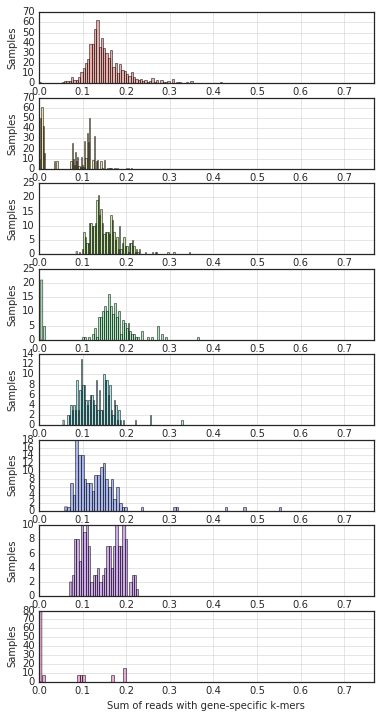

In [12]:
k = 20
reference_gene = 'ZNF17'
palette = sns.color_palette("hls", len(large_populations))
for gene in anchor_genes:
    f, axarr = plt.subplots(4, sharex=True, figsize=(6, 12))
    # add color
    whole_anchor = df_whole[kmers[20][gene]].sum(axis=1)
    whole_normalizer = df_whole[refs[reference_gene]].sum(axis=1)
    minimum, maximum = (whole_anchor / whole_normalizer).min(), (whole_anchor / whole_normalizer).max()
    print minimum, maximum
    
    for i, population in enumerate(plotting_df.Population):
        try:
            samples = population_dictionary_stripped[population]
            df_tmp = df_whole.ix[samples].dropna()
            plt.subplot(len(large_populations), 1, i+1)
            
            anchor = df_tmp[kmers[20][gene]].sum(axis=1)
            normalizer = df_tmp[refs[reference_gene]].sum(axis=1)
        
            if len(samples) > 200:
                (anchor / normalizer).hist(bins=80, alpha=0.5, color=palette[i])
            else: 
                (anchor / normalizer).hist(bins=30, alpha=0.5, color=palette[i])
            plt.xlim(minimum, maximum)
            plt.ylabel('Samples')
            plt.xlabel('Sum of reads with gene-specific k-mers')

        except:
            print population
    #f.suptitle(gene)
    print gene
    plt.show()
    plt.clf()
    break

0.0 1.45320691429e-05
KIR3DL3


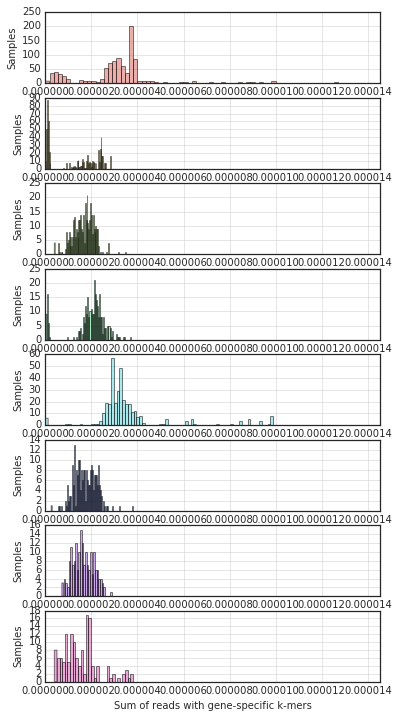

In [23]:
k = 20
palette = sns.color_palette("hls", len(large_populations))
for gene in anchor_genes:
    f, axarr = plt.subplots(4, sharex=True, figsize=(6, 12))
    # add color
    whole_anchor = df_whole[kmers[20][gene]].sum(axis=1)
    whole_normalizer = df_whole[four_mers].sum(axis=1)
    minimum, maximum = (whole_anchor / whole_normalizer).min(), (whole_anchor / whole_normalizer).max()
    print minimum, maximum
    
    for i, population in enumerate(plotting_df.Population):
        try:
            samples = population_dictionary_stripped[population]
            df_tmp = df_whole.ix[samples].dropna()
            plt.subplot(len(large_populations), 1, i+1)
            
            anchor = df_tmp[kmers[20][gene]].sum(axis=1)
            normalizer = df_tmp[four_mers].sum(axis=1)
        
            if len(samples) > 200:
                (anchor / normalizer).hist(bins=80, alpha=0.5, color=palette[i])
            else: 
                (anchor / normalizer).hist(bins=30, alpha=0.5, color=palette[i])
            plt.xlim(minimum, maximum)
            plt.ylabel('Samples')
            plt.xlabel('Sum of reads with gene-specific k-mers')

        except:
            print population
    #f.suptitle(gene)
    print gene
    plt.show()
    plt.clf()
    break